## Importing Modules

In [72]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import math

## DataFrame

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/thomasreji155/Time-Series-Analysis/main/dataset/AirPassengers.csv')
df.columns = ['month','passengers']
df.month = pd.to_datetime(df.month)
df.set_index(df.month,inplace = True)
df.drop('month', axis = 1, inplace = True)
df.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Importing Keras functions


In [37]:
from keras.models import Sequential
from keras.layers import Dense 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import tensorflow as tf

## Time series plot 

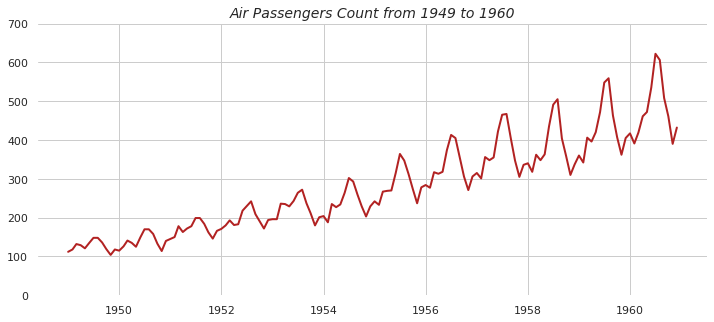

In [82]:
sns.set()
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.ylim(0,700)
plt.plot('passengers',data = df,color = 'firebrick',linewidth = 2)
plt.title('Air Passengers Count from 1949 to 1960', fontstyle ='italic',fontsize = 14)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.box(False)

In [83]:
#Convert pandas dataframe to numpy array
dataset = df.values
dataset = dataset.astype('float32') #COnvert values to float

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)

In [85]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [86]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [87]:
seq_size = 10 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

In [88]:
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [89]:
model = Sequential()
model.add(Dense(64, input_dim=seq_size, activation='relu')) #12
model.add(Dense(32, activation='relu'))  #8
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['acc'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                704       
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=0, epochs=100)

In [91]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [92]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [93]:
trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 15.42 RMSE


In [94]:
testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 32.29 RMSE


In [95]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [96]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

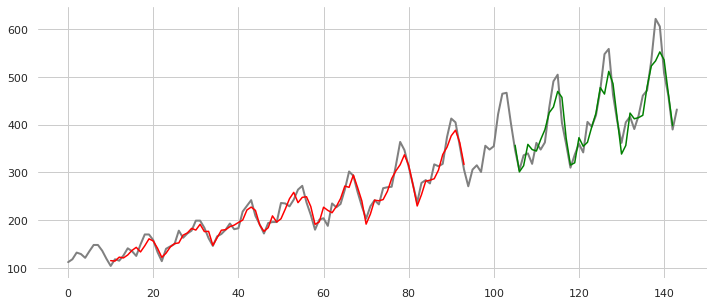

In [106]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.plot(scaler.inverse_transform(dataset), color = 'grey',
         linewidth = 2)
plt.plot(trainPredictPlot,color = 'red')
plt.plot(testPredictPlot, color = 'green')
plt.box(False)
plt.show()